# Automatic Differentiation

Automatic differentiation is a computing technique that uses chain rule to evaluate the gradients of functions. The core idea behind automatic differentiation is to track the sequence of operations that are performed on the inputs to a function, and then use the chain rule to compute the gradient of the output with respect to the inputs. 

## Learning Objectives
- Learn the concept of automatic differentiation.
- Gain a qualitative understanding of the backpropagation algorithm and how it is used to compute gradients.
- Demonstrate how to use automatic differentiation in PyTorch.

## What is Automatic Differentiation?
In brief, automatic differention is chain rule implemented on a computer.  Packages that implement automatic differentiation (e.g. PyTorch, JAX, TensorFlow) track the sequence of operations performed on the inputs to a function.  Then, once a gradient is requested, the package goes back through the sequence of operations and applies the chain rule to compute the gradient of the output with respect to the inputs.  This process is often referred to as "backpropagation" in the context of neural networks, but it is a general technique that can be applied to any function that can be expressed as a sequence of operations.

Below, we demonstrate how to use automatic differentiation in PyTorch.


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Tensors are pytorch's equivalent of numpy arrays.  Here, we set `requires_grad=True` to indicate that we want to compute gradients with respect to this tensor.  By default, PyTorch does not compute gradients for tensors, so we need to explicitly specify which tensors we want to track for gradient computation.

In [2]:
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  
y = torch.sum(a**2)  # Compute the sum of squares of the elements in `a`.  
y.backward()  # Compute the gradient of `y` with respect to `a`.
print(a.grad)  # Print the computed gradient, which should be [2.0, 4.0, 6.0].

tensor([2., 4., 6.])


/home/erik/mambaforge/envs/compmethods/lib/python3.11/site-packages/torch/autograd/graph.py:865: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Pytorch keeps the gradients in the `.grad` attribute of the tensor.  Note: these persist, and are sometimes not automatically cleared, so you may need to clear them manually (e.g. by setting `a.grad = None`) if you want to compute gradients multiple times in a loop.  For instance, consider the following example:

In [3]:
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  
y1 = torch.sum(a**2)  # Compute the sum of squares of the elements in `a`.  
y1.backward()  # Compute the gradient of `y` with respect to `a`.
print(a.grad)  # Print the computed gradient, which should be [2.0, 4.0, 6.0].

y2 = torch.sum(a**3)  # Compute the sum of cubes of the elements in `a`.
y2.backward()  # Compute the gradient of `y` with respect to `a`.

print(a.grad)  # The gradient is now the sum of the gradients from both backward calls, which should be [2.0 + 3*1.0^2, 4.0 + 3*2.0^2, 6.0 + 3*3.0^2] = [5.0, 16.0, 33.0].

tensor([2., 4., 6.])
tensor([ 5., 16., 33.])


If we want to compute the gradient of *only* the second operation (i.e. the sum of cubes), we can clear the gradients after the first backward call using `a.grad.zero_()` or `a.grad = None` before calling `backward()` again.

In [4]:
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  
y1 = torch.sum(a**2)  
y1.backward()  
print(a.grad)  
a.grad.zero_()  # Clear the gradients before the next backward call.

y2 = torch.sum(a**3)
y2.backward()

print(a.grad)

tensor([2., 4., 6.])
tensor([ 3., 12., 27.])


## Implementing Linear Regression with Automatic Differentiation

Let's use this to implement a simple version of linear regression using gradient descent. First, we generate some synthetic data for linear regression. We will create a dataset of input-output pairs where the output is a linear function of the input plus some noise.


In [5]:
X_train = torch.randn(100, 3)  # 100 samples, 3 feature
X_valid = torch.randn(20, 3)   # 20 samples, 3 features

true_weights = torch.tensor([2.0, -3.0, 1.0])  # True weights for the linear model
y_train = X_train @ true_weights + 0.5 * torch.randn(100)  # Linear relationship with some noise
y_valid = X_valid @ true_weights + 0.5 * torch.randn(20)  # Linear relationship with some noise

Next, we initialize the weights of our linear model and set `requires_grad=True` so that we can compute gradients with respect to these weights.

Learned weights: tensor([ 2.0048, -2.9630,  0.9697], requires_grad=True)


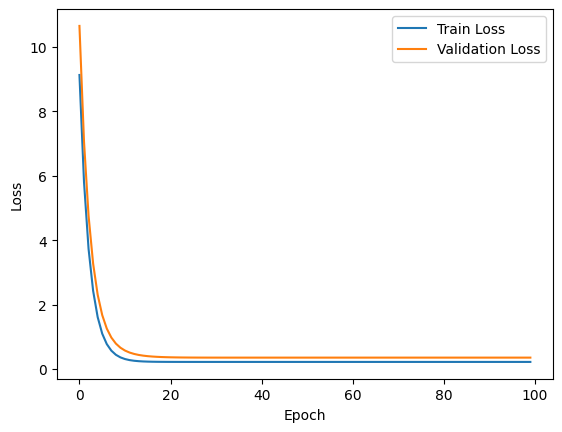

In [7]:
w = torch.randn(3, requires_grad=True)  # Initialize weights for the linear model randomly and set requires_grad=True to track gradients.
dt = 0.1  # Learning rate

train_losses = []
val_losses = []

def linear_model(X, w):
    return X @ w  # Compute the predicted outputs by multiplying the input features with the weights.


for epoch in range(100):
    y_pred = linear_model(X_train, w)  # Get the predicted outputs from the linear model.
    loss = torch.mean((y_pred - y_train) ** 2)  # Compute the mean squared error loss.
    loss.backward()  # Compute the gradient of the loss with respect to the weights.
    train_losses.append(loss.item())  # Store the loss value for plotting later.  The `.item()` method is used to get the scalar value from a one-element tensor.
    
    with torch.no_grad():  
        val_pred = linear_model(X_valid, w)  # Get the predicted outputs for the validation set.
        val_loss = torch.mean((val_pred - y_valid) ** 2)  # Compute the validation loss and store it for plotting.
        val_losses.append(val_loss.item())

        w -= dt * w.grad  # Update the weights by moving in the direction of the negative gradient.
        w.grad.zero_() 

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

print("Learned weights:", w)

As we see, the learned weights are close to the true weights!

# Pytorch Optimizers
In general, you do not need to implement the gradient descent update rule yourself, as PyTorch provides a variety of optimization algorithms in the `torch.optim` module.  For instance, we can use the `SGD` optimizer to perform stochastic gradient descent on our linear regression model.  Other popular choices of optimizer include `Adam`, `RMSprop`, and `Adagrad`: `Adam` is a particularly popular choice that is commonly used for deep neural networks.

In [8]:
import torch.optim as optim

w = torch.randn(3, requires_grad=True)  # Re-initialize weights for the linear model randomly and set requires_grad=True to track gradients.

# Create an SGD optimizer that will update the weights `w` with a learning rate of 0.1.  All of the tensors you want to optimize should be
# passed into the optimizer in a list (or iterable).  In this case, we only have one tensor `w` that we want to optimize, so we pass it in a list as `[w]`.
optimizer = optim.SGD([w], lr=0.1)  

train_losses = []
val_losses = []

adam_losses = []
for epoch in range(100):
    y_pred = linear_model(X_train, w)  # Get the predicted outputs from the linear model.
    loss = torch.mean((y_pred - y_train) ** 2)  # Compute the mean squared error loss.
    loss.backward()  # Compute the gradient of the loss with respect to the weights.
    train_losses.append(loss.item())  # Store the loss value for plotting later.

    with torch.no_grad():  
         val_pred = linear_model(X_valid, w)  # Get the predicted outputs for the validation set.
         val_loss = torch.mean((val_pred - y_valid) ** 2)  # Compute the validation loss and store it for plotting.
         val_losses.append(val_loss.item())
    
    optimizer.step()  # Update the weights using the Adam optimizer. This will internally use the gradients computed by `loss.backward()` to update `w`.
    optimizer.zero_grad()  # Clear the gradients after updating the weights, so that they do not accumulate across iterations.

# Classes and Pytorch Modules.

So far, we have been working with raw tensors and manually implementing the linear regression model.  However, if we want to build more complex models, keeping track of all of the parameters and their gradients can be cumbersome.  To organize this, we will group our code into objects.  In python, an object is a data structure that contains both data and functions that operate on that data.  You have already seens some objects without knowing it: for instance, a list is an object that contains data (the elements of the list) and functions that operate on that data (e.g. `append`, `pop`, etc.).  Similarly, a pytorch tensor is an object that contains data (the values of the tensor, any gradient information) and functions that operate on that data (e.g. `backward`, `grad`, etc.).

In python, each object is a specific instance of a "class."  (The analogy would be that a class is like a blueprint for an object, and an object is an instance of that blueprint.)  Pytorch has multiple built-in classes.  For instance, the `nn.Linear` class implements a linear operation, and `nn.Sigmoid` implements the sigmoid activation function.

In [16]:
linear_operation = torch.nn.Linear(3, 1)  # Create a object of the nn.Linear class that takes 3 input features and produces 1 output feature.
print("weight:", linear_operation.weight)  # Print the weights of the linear layer.
print("bias:", linear_operation.bias)  # Print the bias of the linear layer.

print("~~~~~~~~~~")
# All of the parameters can be accessed as a list using the `parameters()` method of the linear layer.  This is useful for passing the parameters to an optimizer.
print("parameters:", list(linear_operation.parameters()))  # Print the parameters of the linear layer as a list.

x_test = torch.tensor([1., 2., 3.])  # Create a test input tensor with 3 features.

print("~~~~~~~~~~")
# However, we can also apply the linear layer to our input data `X` to get the predicted outputs by calling it as a function.
predicted_outputs = linear_operation(x_test)  # Apply the linear layer to the input data `X` to get the predicted outputs.
print("--- output of linear layer ---")
print(predicted_outputs) 
# Alternatively, we can also call the `forward` method of the linear layer directly to get the same result.
predicted_outputs_forward = linear_operation.forward(x_test) 
print(predicted_outputs_forward) 



weight: Parameter containing:
tensor([[ 0.2166,  0.2370, -0.2168]], requires_grad=True)
bias: Parameter containing:
tensor([-0.0272], requires_grad=True)
~~~~~~~~~~
parameters: [Parameter containing:
tensor([[ 0.2166,  0.2370, -0.2168]], requires_grad=True), Parameter containing:
tensor([-0.0272], requires_grad=True)]
~~~~~~~~~~
--- output of linear layer ---
tensor([0.0130], grad_fn=<ViewBackward0>)
tensor([0.0130], grad_fn=<ViewBackward0>)


Using the pytorch linear layer, we can implement the same linear regression model as follows:

Learned weights: Parameter containing:
tensor([[ 2.0006, -2.9585,  0.9656]], requires_grad=True)
Learned bias: Parameter containing:
tensor([0.0971], requires_grad=True)


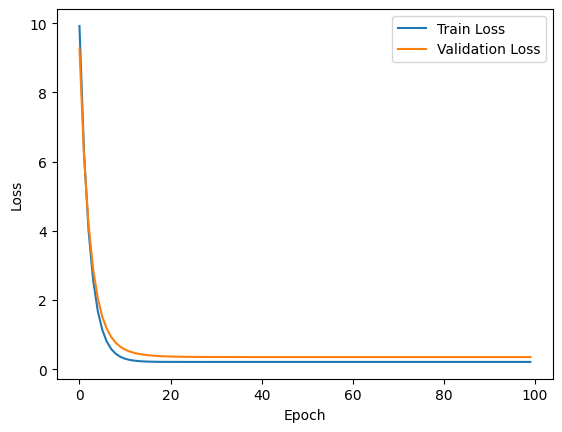

In [11]:
linear = torch.nn.Linear(3, 1) 
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

train_losses = []
val_losses = []

for epoch in range(100):
    y_pred = linear(X_train).squeeze()  # Get the predicted outputs from the linear model.  The `squeeze()` method is used to remove any extra dimensions from the output tensor, since `nn.Linear` will return a tensor of shape (100, 1) and we want it to be of shape (100,).
    loss = torch.mean((y_pred - y_train) ** 2)  # Compute the mean squared error loss.
    loss.backward()  # Compute the gradient of the loss with respect to the weights.
    train_losses.append(loss.item())  # Store the loss value for plotting later.
    
    optimizer.step()  # Update the weights using the SGD optimizer. This will internally use the gradients computed by `loss.backward()` to update the parameters of the linear layer.

    with torch.no_grad():  
        val_pred = linear(X_valid).squeeze()  # Get the predicted outputs for the validation set.
        val_loss = torch.mean((val_pred - y_valid) ** 2)  # Compute the validation loss and store it for plotting.
        val_losses.append(val_loss.item())
    optimizer.zero_grad()  # Clear the gradients after updating the weights, so that they do not accumulate across iterations.

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

print("Learned weights:", linear.weight)
print("Learned bias:", linear.bias)


You can build your own custom classes using the `class` keyword in python.  For instance a simple class for holding information about an NMR spectrum could be implemented as below.

In [18]:
class NMRSpectrum:
    def __init__(self, frequencies, intensities):
        self.frequencies = frequencies  # Store the frequencies of the NMR spectrum.
        self.intensities = intensities  # Store the intensities of the NMR spectrum.

    def plot(self):
        plt.stem(self.frequencies, self.intensities)  # Create a stem plot of the frequencies and intensities.
        plt.xlabel('Frequency (ppm)')  # Label the x-axis as 'Frequency (ppm)'.
        plt.ylabel('Intensity')  # Label the y-axis as 'Intensity'.
        plt.title('NMR Spectrum')  # Set the title of the plot to 'NMR Spectrum'.
        plt.show()  # Display the plot.
        

This class has two attributes: `frequencies` and `intensities`. These are initialized in the constructor (`__init__` method), which runs when you first create an instance of the class.  The class also has a method called `plot` that uses matplotlib to plot the spectrum.  To use this class, you would create an instance of it and then call the `plot` method on that instance.

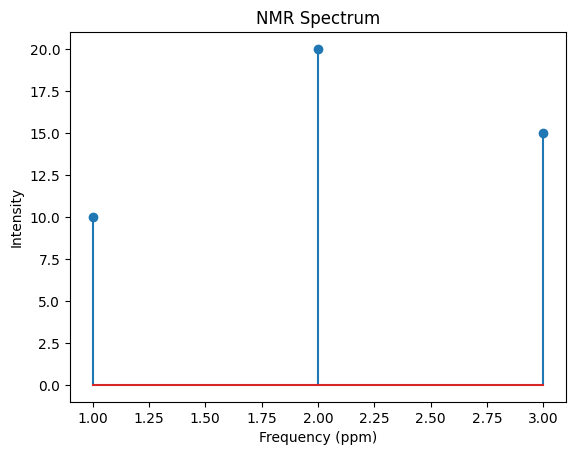

In [19]:
spectrum = NMRSpectrum(frequencies=[1, 2, 3], intensities=[10, 20, 15])  # Yes these are not realistic frequencies and intensities, don't @ me.
spectrum.plot()  # Call the plot method to visualize the NMR spectrum.

Classes are a powerful way to organize your code and data.  Moreover, you can build classes that "inherit" from other classes: they automatically get all of the attributes and methods of the parent class, preventing you from having to rewrite code.  This is particularly useful in pytorch: if you make a class that inherits from `torch.nn.Module`, you can use all of the functionality of a pytorch module, including automatic tracking of parameters and gradients, and easy saving/loading of model weights.  Below is an example where we have implemented a logistic regression model,

In [ ]:
class LogisticModel(torch.nn.Module):  # We are inheriting from the `torch.nn.Module` class, which is the base class for all neural network modules in PyTorch.
    def __init__(self, input_dim):
        super(LogisticModel, self).__init__()   # This runs the constructor of the parent class (`torch.nn.Module`) which is necessary to set up all the pytorch internal machinery.
        self.linear = torch.nn.Linear(input_dim, 1)  # Create a linear layer that takes `input_dim` features and produces 1 output feature.
        self.nonlinearity = torch.nn.Sigmoid()  # Create a sigmoid activation function.

    def forward(self, x):  # The Forward method defines how the input data `x` flows through the layers of the model to produce the output.  
        x = self.linear(x)  # Apply the linear layer to the input `x`.
        x = self.nonlinearity(x)  # Apply the sigmoid activation function to the output of the linear layer.
        return x 

# Using GPU/TPU with PyTorch

Pytorch also provides support for GPU and TPU acceleration.  To use a GPU or TPU, you need to move your tensors and models to the appropriate device.  For instance, to move a tensor to the GPU, you can use the `to` method as follows.

Alternatively, whenever possible it is better practice to create the tensors directly on the GPU by specifying the device when creating the tensor.  For instance, you can create a tensor on the GPU in its constructor.


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if a GPU is available and set the device accordingly.
my_tensor = torch.tensor([1.0, 2.0, 3.0])  # Create a tensor on the CPU.
my_tensor_on_gpu = my_tensor.to(device)  # Move the tensor to the GPU if available, otherwise it will remain on the CPU.

a_second_tensor = torch.tensor([4.0, 5.0, 6.0], device=device)  # Create another tensor on the GPU.

When working on GPU, make sure to move all of the data, parameters, and objects to the GPU using the `to` method.  Otherwise, you can get errors about tensors being on different devices! 